# Factor Momentum (India)

We explore if factor out-performance persists in Indian factor/strategy indices.

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(pracma)
library(ggthemes)
library(reshape2)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)
library(ggpubr)

options(repr.plot.width=16, repr.plot.height=8)
options(tibble.width = Inf)

indices <- Indices()

In [2]:
indexNames <- c('NIFTY ALPHA 50 TR',
                'NIFTY LOW VOLATILITY 50 TR',
                'NIFTY200 QUALITY 30 TR',
                'NIFTY500 VALUE 50 TR',
                'NIFTY 50 TR',
                'NIFTY MIDCAP 50 TR')

minMaxIndexDates <- indices$NseTimeSeries() %>%
    filter(NAME %in% indexNames) %>%
    group_by(NAME) %>%
    summarize(S=min(TIME_STAMP), E=max(TIME_STAMP)) %>%
    collect() %>%
    mutate(S=as.Date(S), E=as.Date(E))

if (!all(minMaxIndexDates$E == max(minMaxIndexDates$E))) {
    stop("End dates don't match. Check if your indices are current.")
}

print(minMaxIndexDates)

startDate <- max(minMaxIndexDates$S)
endDate <- minMaxIndexDates$E[1]

# A tibble: 6 x 3
  NAME                       S          E         
  <chr>                      <date>     <date>    
1 NIFTY 50 TR                1999-06-30 2019-12-09
2 NIFTY ALPHA 50 TR          2003-12-31 2019-12-09
3 NIFTY LOW VOLATILITY 50 TR 2003-12-31 2019-12-09
4 NIFTY MIDCAP 50 TR         2004-01-01 2019-12-09
5 NIFTY200 QUALITY 30 TR     2005-04-01 2019-12-09
6 NIFTY500 VALUE 50 TR       2005-04-01 2019-12-09


In [3]:
monthlies <- NULL
for(iName in indexNames){
    px <- indices$NseTimeSeries() %>%
        filter(NAME == iName & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
        select(TIME_STAMP, CLOSE) %>%
        collect() %>%
        mutate(TIME_STAMP = as.Date(TIME_STAMP))
    
    monthlies <- merge.xts(monthlies, monthlyReturn(xts(px$CLOSE, px$TIME_STAMP)))
}

monthlies <- monthlies[-1,]
monthlies <- monthlies[-nrow(monthlies), ]
names(monthlies) <- indexNames

In [4]:
allRets <- na.omit(merge(monthlies, stats::lag(monthlies, -1)))

In [5]:
print(head(print(head(allRets))))

           NIFTY.ALPHA.50.TR NIFTY.LOW.VOLATILITY.50.TR NIFTY200.QUALITY.30.TR
2005-05-31       0.056562391                 0.09286822             0.08360599
2005-06-30       0.006335569                 0.04164045             0.05711650
2005-07-29       0.146237495                 0.07248245             0.04486467
2005-08-31       0.122576887                 0.04829083             0.03254870
2005-09-30       0.056739100                 0.07738423             0.08568923
2005-10-31      -0.120946527                -0.07916005            -0.08610050
           NIFTY500.VALUE.50.TR NIFTY.50.TR NIFTY.MIDCAP.50.TR
2005-05-31           0.10349501  0.09876928         0.07342644
2005-06-30          -0.02157852  0.06829024         0.01478303
2005-07-29           0.11645011  0.04281269         0.14378858
2005-08-31           0.05737374  0.03347177         0.05997824
2005-09-30           0.04360286  0.09427585         0.04063158
2005-10-31          -0.10637502 -0.08814311        -0.11766223
      

## Buy whatever gave highest returns in the last 12-months

In [6]:
lb <- 12
factorMomXts <- rollapply(allRets, lb, function(X){
    cumRets <- c()
    for(i in 1:length(indexNames)){
        cumRets <- c(cumRets, as.numeric(Return.cumulative(X[,i])))
    }
    maxIndex <- which.max(cumRets)
    return(xts(matrix(c(maxIndex, X[lb, maxIndex + length(indexNames)]), nrow=1), last(index(X))))
}, by.column = F)

factorMomXts <- na.omit(factorMomXts)
names(factorMomXts) <- c('F', 'RET')

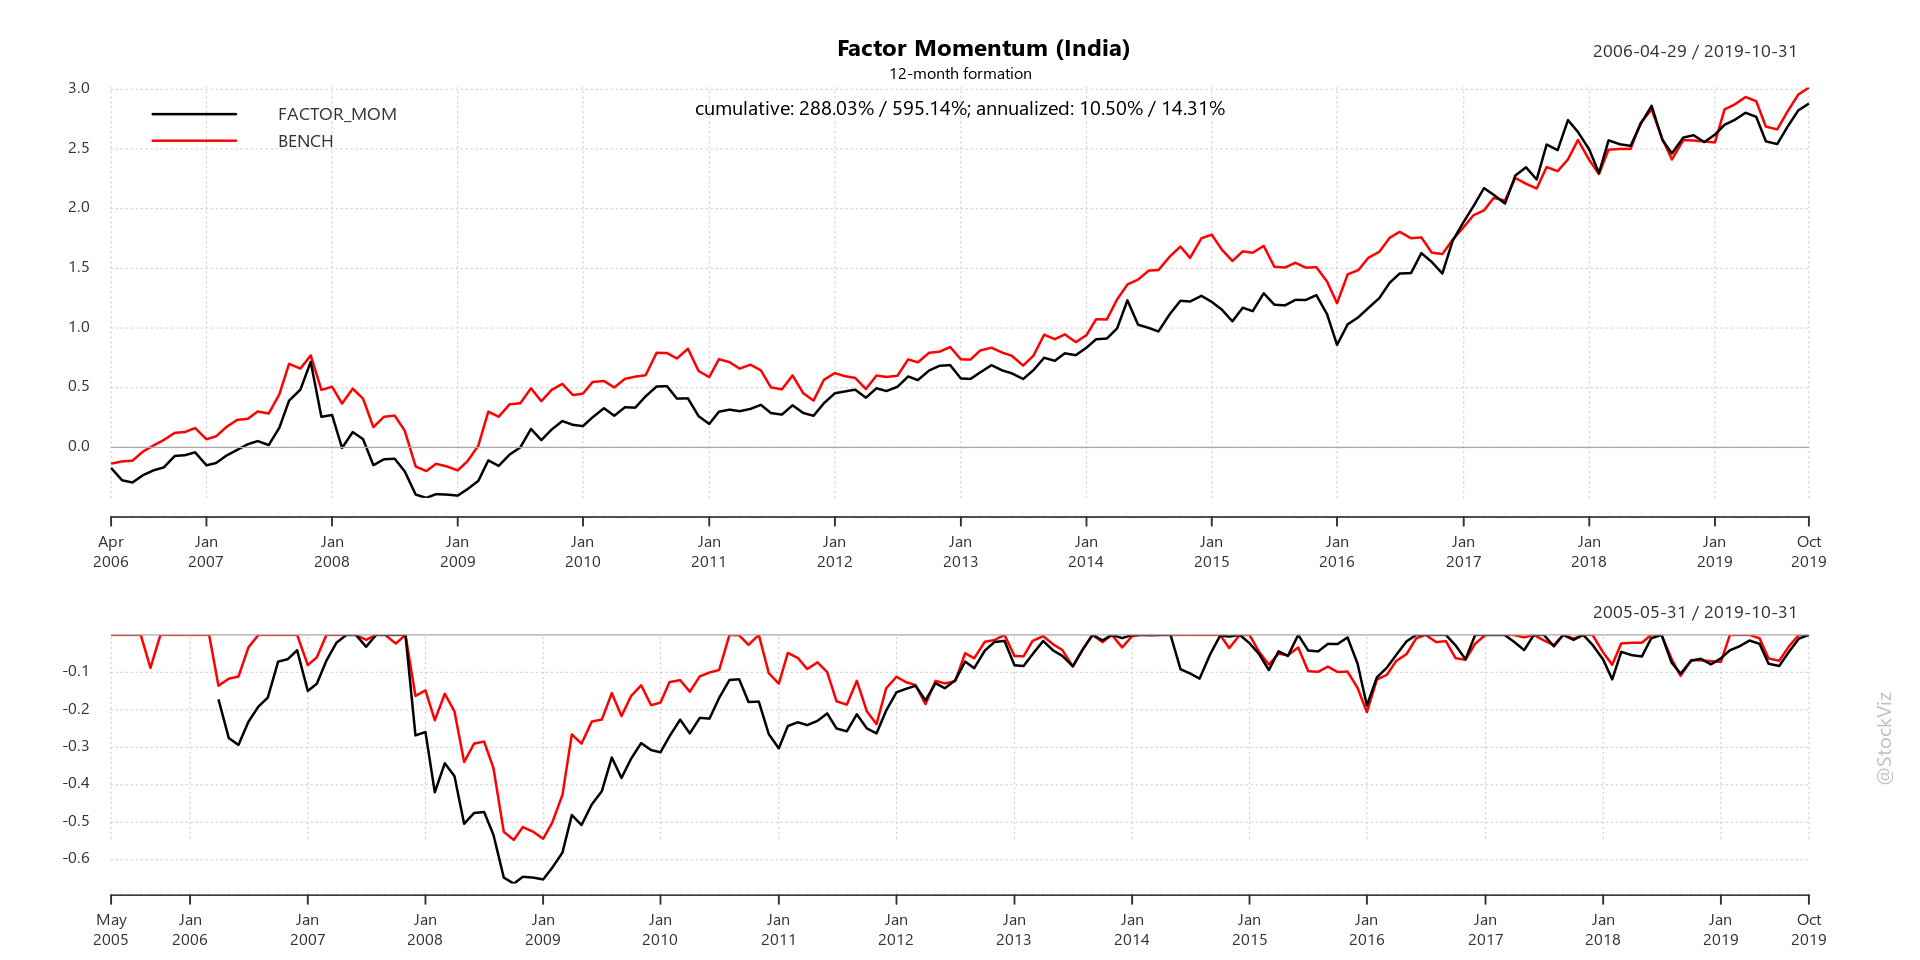

In [7]:
toPlot <- merge(factorMomXts$RET, allRets[, 'NIFTY.50.TR.1'])
names(toPlot) <- c('FACTOR_MOM', 'BENCH')
Common.PlotCumReturns(toPlot, "Factor Momentum (India)", "12-month formation")

## Buy whatever had the highest average returns over the last 6, 7, 8, 9, 10, 11 and 12-months

In [8]:
lb <- 12
factorMomXts2 <- rollapply(allRets, lb, function(X){
    cumRets <- c()
    for(i in 1:length(indexNames)){
        totalRet <- as.numeric(Return.cumulative(X[7:12,i])) +
            as.numeric(Return.cumulative(X[6:12,i])) +
            as.numeric(Return.cumulative(X[5:12,i])) +
            as.numeric(Return.cumulative(X[4:12,i])) + 
            as.numeric(Return.cumulative(X[3:12,i])) +
            as.numeric(Return.cumulative(X[2:12,i])) +
            as.numeric(Return.cumulative(X[1:12,i]))
        cumRets <- c(cumRets, totalRet/7)
    }
    maxIndex <- which.max(cumRets)
    return(xts(matrix(c(maxIndex, X[lb, maxIndex + length(indexNames)]), nrow=1), last(index(X))))
}, by.column = F)

factorMomXts2 <- na.omit(factorMomXts2)
names(factorMomXts2) <- c('F', 'RET')

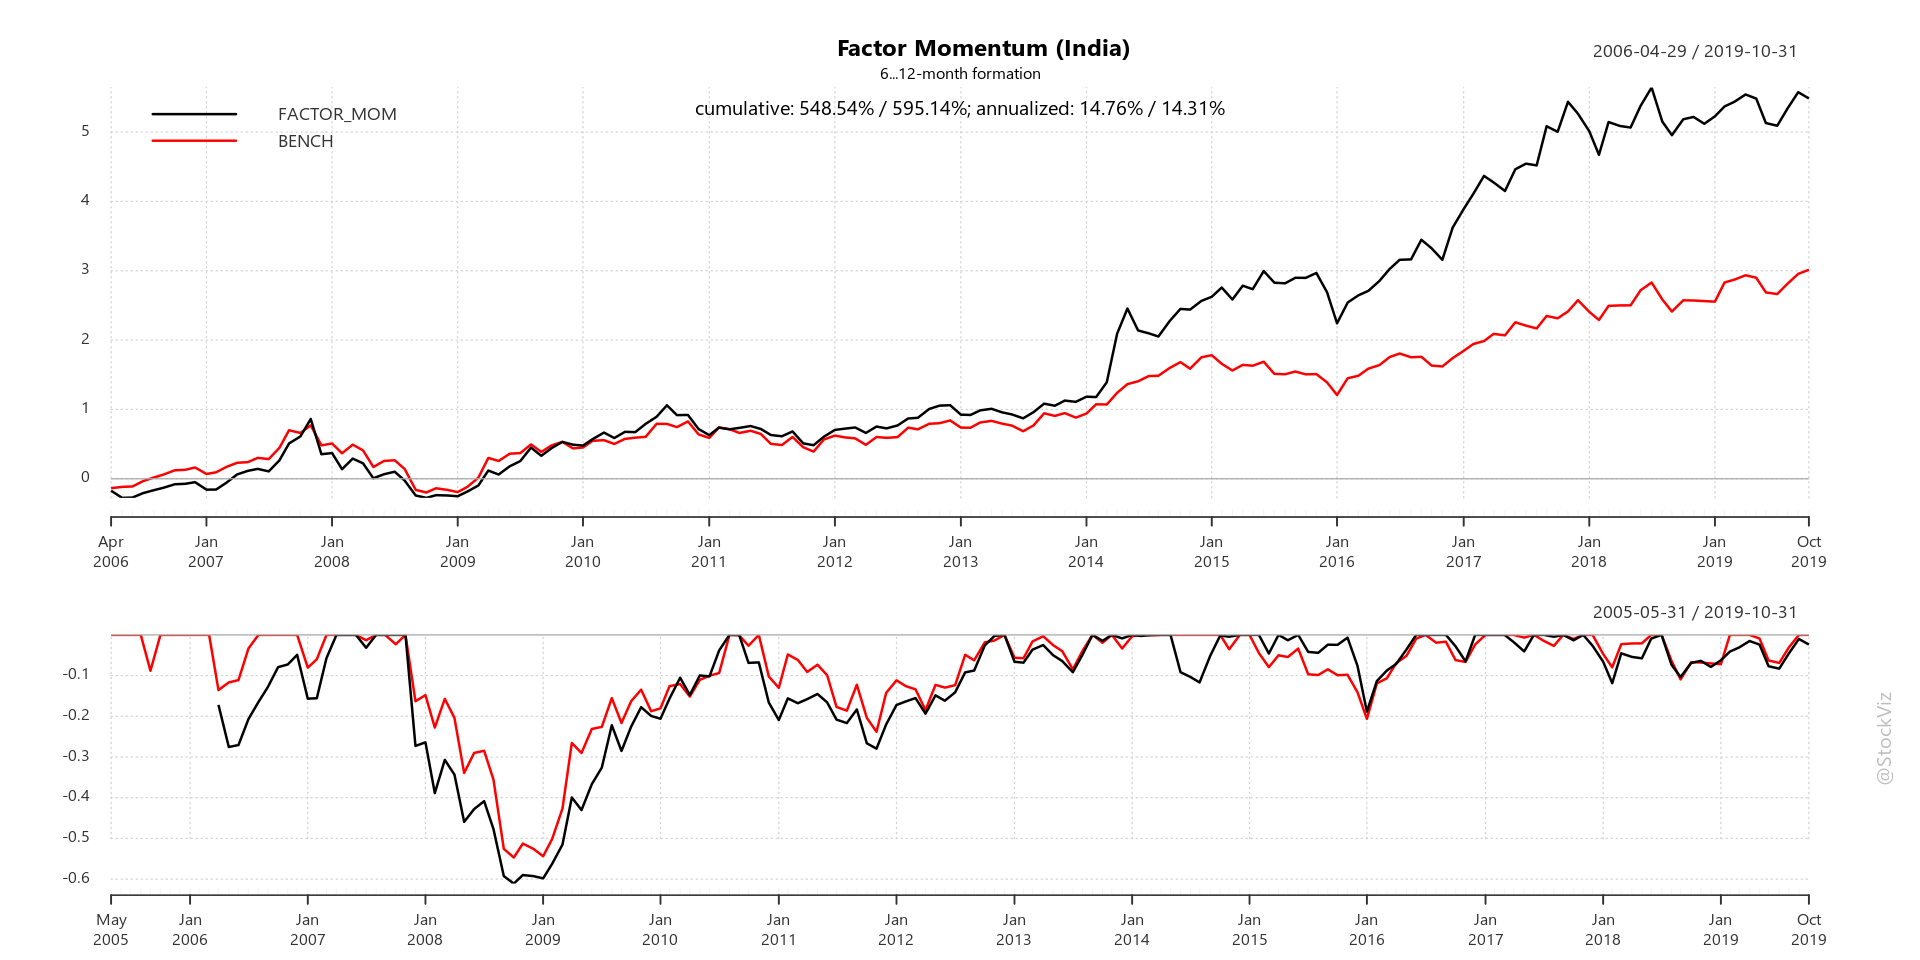

In [9]:
toPlot <- merge(factorMomXts2$RET, allRets[, 'NIFTY.50.TR.1'])
names(toPlot) <- c('FACTOR_MOM', 'BENCH')
Common.PlotCumReturns(toPlot, "Factor Momentum (India)", "6...12-month formation")

## Buy whatever gave the highest return the previous month

In [10]:
lb <- 1
factorMomXts <- rollapply(allRets, lb, function(X){
    maxIndex <- as.numeric(which.max(X[, 1:length(indexNames)]))
    return(xts(matrix(c(maxIndex, X[lb, maxIndex + length(indexNames)]), nrow=1), last(index(X))))
}, by.column = F)

factorMomXts <- na.omit(factorMomXts)
names(factorMomXts) <- c('F', 'RET')

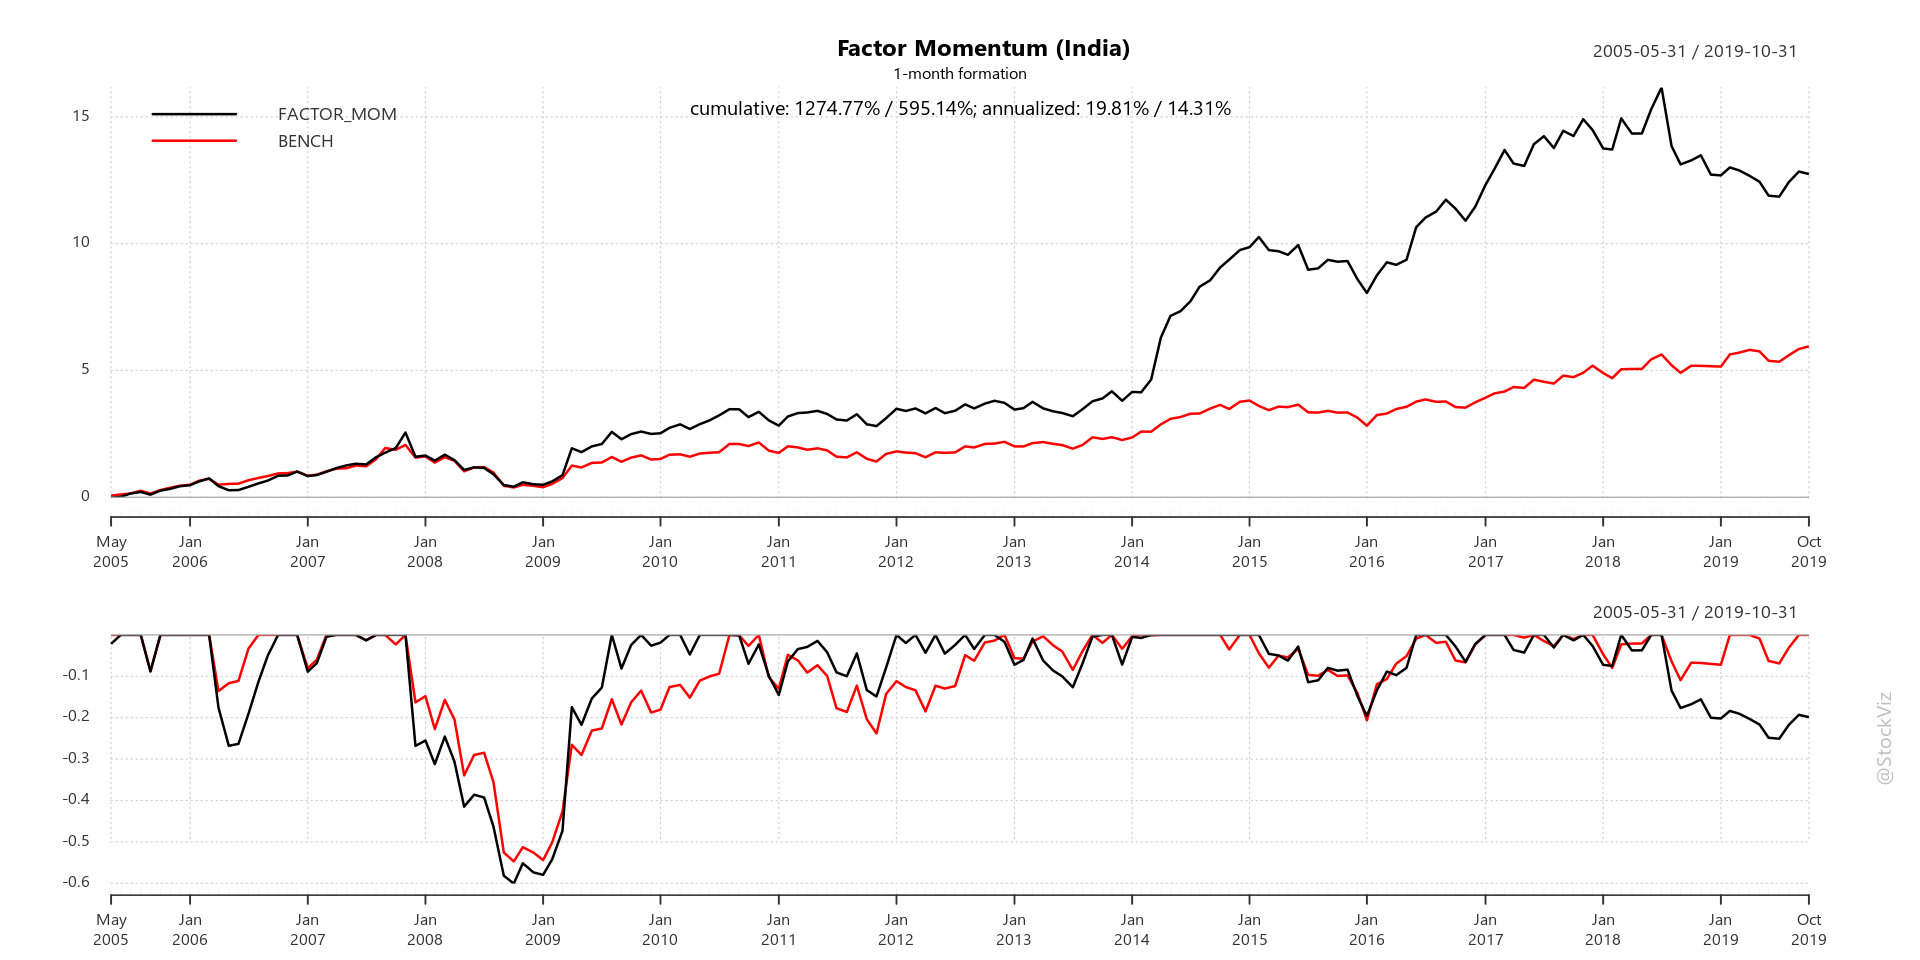

In [11]:
toPlot <- merge(factorMomXts$RET, allRets[, 'NIFTY.50.TR.1'])
names(toPlot) <- c('FACTOR_MOM', 'BENCH')
Common.PlotCumReturns(toPlot, "Factor Momentum (India)", "1-month formation")

## Buy whatever gave lowest returns in the last 12-months

In [12]:
factorMomXts <- rollapply(allRets, lb, function(X){
    cumRets <- c()
    for(i in 1:length(indexNames)){
        cumRets <- c(cumRets, as.numeric(Return.cumulative(X[,i])))
    }
    minIndex <- which.min(cumRets)
    return(xts(matrix(c(minIndex, X[lb, minIndex + length(indexNames)]), nrow=1), last(index(X))))
}, by.column = F)

factorMomXts <- na.omit(factorMomXts)
names(factorMomXts) <- c('F', 'RET')

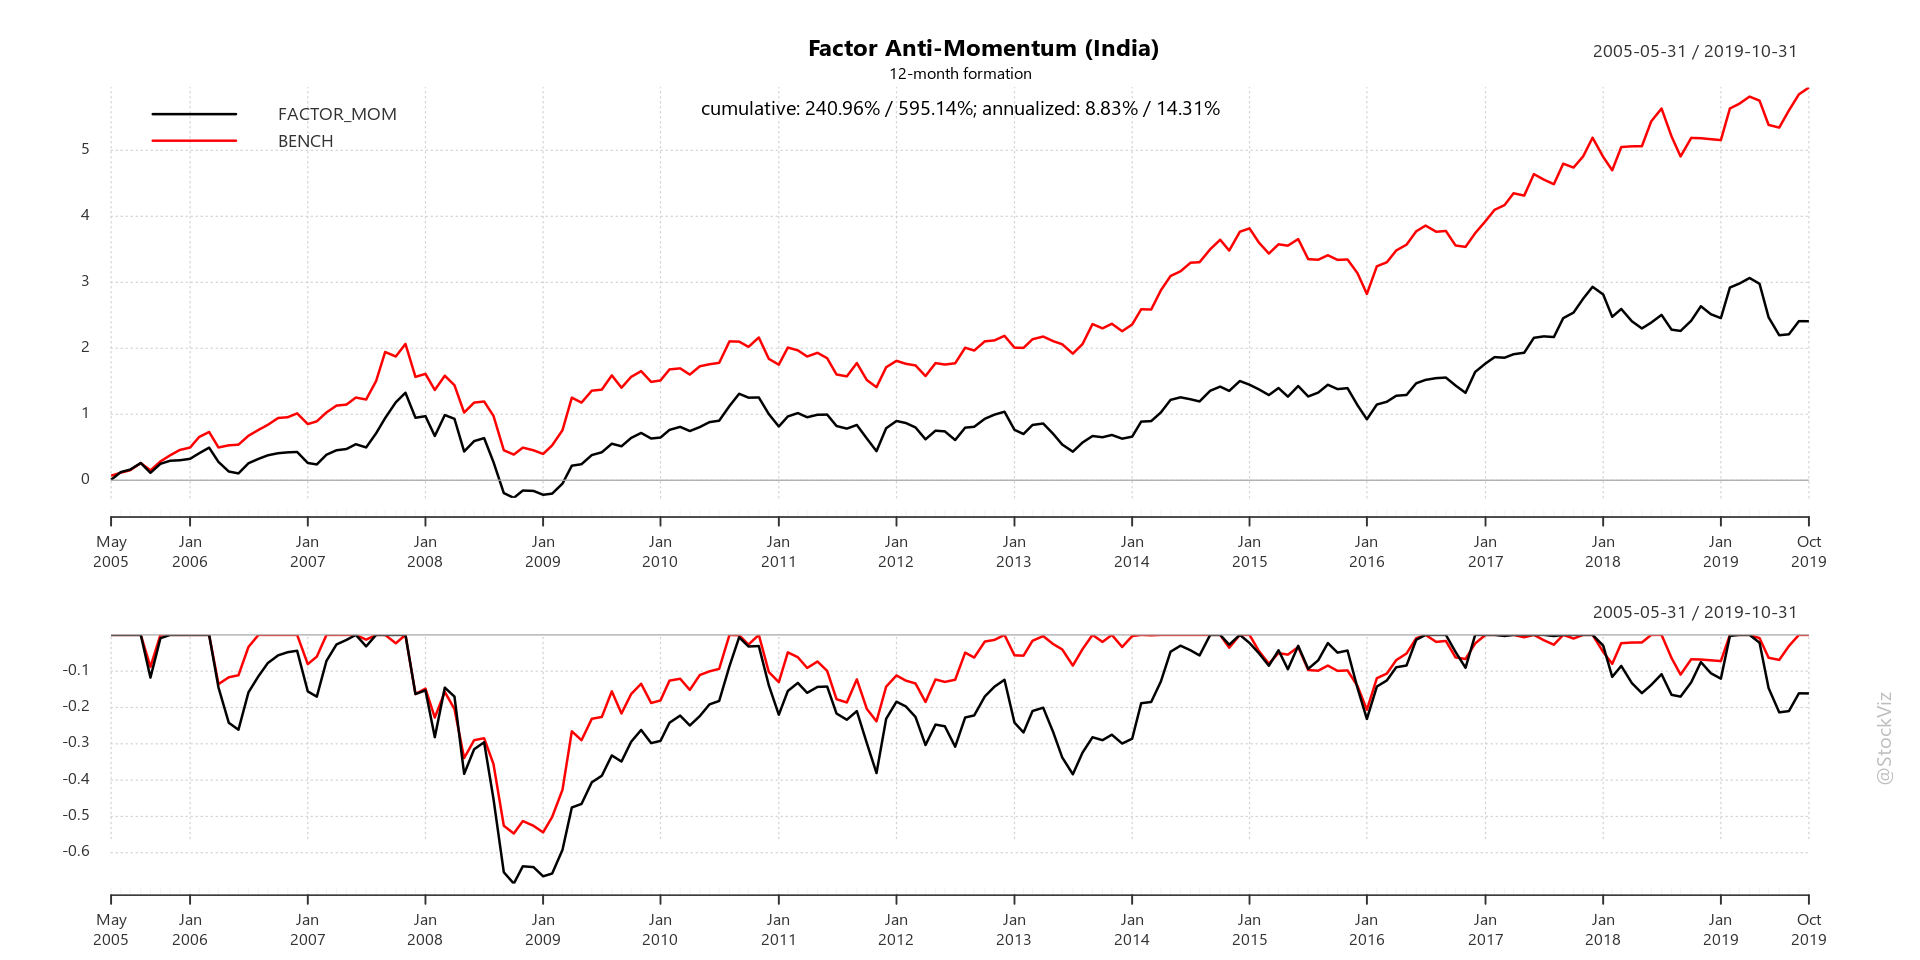

In [13]:
toPlot <- merge(factorMomXts$RET, allRets[, 'NIFTY.50.TR.1'])
names(toPlot) <- c('FACTOR_MOM', 'BENCH')
Common.PlotCumReturns(toPlot, "Factor Anti-Momentum (India)", "12-month formation")

This notebook was created using [pluto](https://pluto.studio). Thank you for playing fair!